# BIENVENIDO!

<br />

## PROCESAMIENTO DE CSV PARA TWITTER

## Clasificación de sentimientos y emociones

**Por favor, el nombre del archivo ".csv" que esté escrito todo en minúsculas y que no use "_"**

**Es para evitar conflictos con la interface lógica**

**El usuario debe configurar variables en la 2da Celda**

**Ingrese el nombre del archivo y el valor True en la red social correspondiente**

**Asegurese de que haya un solo filtro de red social activado poniendo False en el otro valor**

<br />
<br />

**Comandos Jupyter Notebook:**<br />

<br />
<center><b>

```
shift + enter: ejecutar celda y pasar a la celda siguiente

ctrl + enter: ejecutar celda y quedarse en la celda correspondiente
```

</b></center>
<br />
<br />
<br />
<br />

In [1]:
import pickle
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch
import time


# APP Reputación Digital
from app.time_series import TimeSeries
from app.m1_sentiment import M1_sentiment
from app.m2_emotions import M2_emotions
from app.m3_emotions import M3_emotions

# Librería Reputación Digital
from tools.feed import data_info

GPU disponible, otorgada mediante el id: cuda:0


**Configurar archivo de lectura y filtro correspondiente:**

In [2]:
## INPUT USUARIO

archivo_lectura = "panorama-economico.csv" # 3000 registros

## INPUT USUARIO

In [3]:
# CARGAR DATASET DE PROCESAMIENTO
path = TimeSeries.main(archivo_lectura)
path = path.rsplit("shared_resources", 1)[1][1:]

Ejecutando time_series/TimeSeries.py

Cargando configuración...
Ejecutando time_series/main.py


    Resumen de la apertura de .csv:

                columna  Nan  pct_nan   dtype  count  pct_reg  count_unique
0        @timestamp    0      0.0  object   6681    100.0          3587
1            author    0      0.0  object   6681    100.0          5312
2           content    0      0.0  object   6681    100.0          6305
3            source    0      0.0  object   6681    100.0          6322
4  rt_retweet_count    0      0.0  object   6681    100.0            19
5     retweet_count    0      0.0  object   6681    100.0           101
    
1. Limpieza del content

Longitud del batch de contenidos: 6681
Tamaño de la muestra neta: 6339
Directorio de salida:
c:\Users\Agustin\Desktop\RD\Octubre\RD_APP\output\panorama-economico
programa finalizado de forma exitosa


In [4]:
# PREDICCION DE SENTIMIENTO # 6340 datos = x143 segundos | 7 minutos
df = M1_sentiment.main_shared_resources(path)
df.head(3)

Cargando configuración...
Leyendo fichero...
Fichero leído con éxito.

Ejecutando modelo optimizado con 4 hilos...
Modelo - clasificación de sentimientos: cardiffnlp/twitter-xlm-roberta-base-sentiment


c:\Users\Agustin\Desktop\RD\Octubre\RD_APP\venv\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Tiempo de ejecución del modelo:  418.6524543762207
Ensamble de las predicciones
Predicción de sentimientos finalizada.


,@timestamp,author,content,source,rt_retweet_count,retweet_count,usuarios_mencionados,hashtags,datetime,date_str,time_str,sentiment_i,score_sentiment_i
0,"Oct 24, 2023 @ 14:54:00.000",jonathanlrusty,ricardo es peronita es verdad y odia los neoli...,https://twitter.com/jonathanlrusty/status/1716...,0,0,[@vickyvillarruel],NaN,2023-10-24 14:54:00,2023-10-24,14:54:00,negative,0.890897
1,"Oct 24, 2023 @ 14:53:00.000",PatataDelNether,la inflacion que anda manejando el super minis...,https://twitter.com/PatataDelNether/status/171...,0,0,"[@braceras_tomas, @eleccionesdatos]",NaN,2023-10-24 14:53:00,2023-10-24,14:53:00,neutral,0.755666
2,"Oct 24, 2023 @ 14:52:00.000",Jcgomez0867,todos no hay casi un 40% o mas que eligen pobr...,https://twitter.com/Jcgomez0867/status/1716875...,0,0,"[@vickyvillarruel, @jmilei]",NaN,2023-10-24 14:52:00,2023-10-24,14:52:00,negative,0.672256


In [5]:
# PREDICCION DE LAS EMOCIONES I # 6340 datos # 249 seg
start = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL = "02shanky/finetuned-twitter-xlm-roberta-base-emotion"
tokenizer_i = AutoTokenizer.from_pretrained(MODEL)
model_i = AutoModelForSequenceClassification.from_pretrained(MODEL)

pipeline_i = pipeline('text-classification', model=model_i, tokenizer=tokenizer_i, device=device, top_k=None)

# Realizar predicción y ajustar resultados
predictions = M2_emotions.classify_tweets(pipeline_i, df, target="content")

predictions = M2_emotions.emotions_features(predictions)

# update dataset
df = pd.concat([df, predictions], axis=1)
end = time.time()

print(f"tiempo de ejecución: {end - start} segs")

AttributeError: module 'app.m2_emotions.M2_emotions' has no attribute 'emotions_features'

In [6]:
def emotions_features(prediction:list) -> pd.DataFrame:
# Crear una lista para almacenar los datos de cada columna
  label_columns = []
  score_columns = []
  max_label_column = []

  # Recorrer la lista de predicciones
  for prediction in predictions:
      labels = []
      scores = []
      max_score = 0
      max_label = ''

      # Recorrer cada predicción dentro de la lista
      for pred in prediction:
          label = pred['label']
          score = pred['score']

          labels.append(label)
          scores.append(score)

          # Actualizar la etiqueta con el mayor puntaje
          if score > max_score:
              max_score = score
              max_label = label

      label_columns.append(labels)
      score_columns.append(scores)
      max_label_column.append(max_label)

  # Crear el DataFrame con las columnas correspondientes
  df = pd.DataFrame(
    {'emotions_6_labels': label_columns,
     'emotions_6_scores': score_columns,
     'emotions_6_max_label': max_label_column}
    )

  return df

In [7]:
predictions = emotions_features(predictions)

# update dataset
df = pd.concat([df, predictions], axis=1)

In [8]:
# CLASIFICACION DE EMOCIONES II # 6340 datos # 183 seg
"""
Acá vale una aclaración con respecto a los scores.
Por lo general, un modelo predice etiquetas, y 
le otorga un score entre 0 y 1 a cada etiqueta.

Este modelo no, lo que hace es generar etiquetas,
a cada etiqueta le otorga un score, y la suma de
todos los scores es igual a 1.
"""

start = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "joeddav/distilbert-base-uncased-go-emotions-student"
model_ii = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer_ii = AutoTokenizer.from_pretrained(MODEL_NAME)

pipeline_ii = TextClassificationPipeline(model=model_ii, tokenizer=tokenizer_ii, device=device, top_k=None)

predictions = M3_emotions.classify_tweets(pipeline_ii, df, target="content")
predictions = M3_emotions.emotions_features(predictions)

df = pd.concat([df, predictions], axis=1)

end = time.time()
print(f"tiempo de ejecución: {end - start} segs")

c:\Users\Agustin\Desktop\RD\Octubre\RD_APP\venv\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Agustin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tiempo de ejecución: 895.9039707183838 segs


In [9]:
## ESTADO FINAL DATASET

display(df.head(3))
data_info(df)

,@timestamp,author,content,source,rt_retweet_count,retweet_count,usuarios_mencionados,hashtags,datetime,date_str,time_str,sentiment_i,score_sentiment_i,emotions_6_labels,emotions_6_scores,emotions_6_max_label,emotions_26_labels,emotions_26_scores,emotions_26_max_label
0,"Oct 24, 2023 @ 14:54:00.000",jonathanlrusty,ricardo es peronita es verdad y odia los neoli...,https://twitter.com/jonathanlrusty/status/1716...,0,0,[@vickyvillarruel],NaN,2023-10-24 14:54:00,2023-10-24,14:54:00,negative,0.890897,"[anger, sadness, joy, love, fear, surprise]","[0.9738480448722839, 0.01934608817100525, 0.00...",anger,"[curiosity, confusion, excitement, caring, app...","[0.10054995864629745, 0.0963403582572937, 0.05...",curiosity
1,"Oct 24, 2023 @ 14:53:00.000",PatataDelNether,la inflacion que anda manejando el super minis...,https://twitter.com/PatataDelNether/status/171...,0,0,"[@braceras_tomas, @eleccionesdatos]",NaN,2023-10-24 14:53:00,2023-10-24,14:53:00,neutral,0.755666,"[joy, surprise, anger, fear, sadness, love]","[0.9934844374656677, 0.0027044026646763086, 0....",joy,"[neutral, desire, realization, approval, disap...","[0.063914455473423, 0.05584322661161423, 0.054...",neutral
2,"Oct 24, 2023 @ 14:52:00.000",Jcgomez0867,todos no hay casi un 40% o mas que eligen pobr...,https://twitter.com/Jcgomez0867/status/1716875...,0,0,"[@vickyvillarruel, @jmilei]",NaN,2023-10-24 14:52:00,2023-10-24,14:52:00,negative,0.672256,"[joy, sadness, anger, love, fear, surprise]","[0.7604028582572937, 0.132757306098938, 0.0933...",joy,"[neutral, disappointment, disapproval, annoyan...","[0.11017776280641556, 0.08170522749423981, 0.0...",neutral


,columna,Nan,pct_nan,dtype,count,pct_reg,count_unique
0,@timestamp,0,0.00,object,6176,100.00,3563
1,author,0,0.00,object,6176,100.00,5306
2,content,0,0.00,object,6176,100.00,6175
3,source,0,0.00,object,6176,100.00,6176
4,rt_retweet_count,0,0.00,object,6176,100.00,18
5,retweet_count,0,0.00,object,6176,100.00,96
6,usuarios_mencionados,1483,24.01,object,4693,75.99,2627
7,hashtags,5231,84.70,object,945,15.30,575
8,datetime,0,0.00,datetime64[ns],6176,100.00,3563
9,date_str,0,0.00,object,6176,100.00,5


In [10]:
print(archivo_lectura.split(".")[0] + ".pickle")

panorama-economico.pickle


In [11]:
archivo_lectura = archivo_lectura.split(".")[0] + ".pickle"

with open(archivo_lectura, "wb") as f:
    pickle.dump(df, f)

In [12]:
# DESCARGA
user_input = input("presione Y para guardar csv, cualquier otra tecla para abortar: ")
if user_input.lower() != "y":
    print("Ejecución interrumpida de forma segura.")
    exit()


archivo_descarga= "RD-"+archivo_lectura
df.to_csv(archivo_descarga, index=False)

Ejecución interrumpida de forma segura.


: 

In [ ]:
# DESCARGA DIVIDIDA POR SENTIMIENTO

mask_negativo = (df.sentiment_i == "negative").values
mask_positivo = (df.sentiment_i == "positive").values
mask_neutro = (df.sentiment_i == "neutral").values

df_sentiment_positive= df.loc[mask_positivo]
df_sentiment_negative= df.loc[mask_negativo]
df_sentiment_neutral = df.loc[mask_neutro]

## Conteo de las predicciones
print(f"Predicciones {archivo_lectura}:")
print("Negativos: ", mask_negativo.sum())
print("Positivos: ", mask_positivo.sum())
print("Neutro: ", mask_neutro.sum())


Predicciones carne-nuevo-tw.csv:
Negativos:  240
Positivos:  12
Neutro:  84


In [ ]:
df_sentiment_negative.to_csv(f"RD_negative-{archivo_lectura}")
df_sentiment_positive.to_csv(f"RD_positive-{archivo_lectura}")
df_sentiment_neutral.to_csv(f"RD_neutral-{archivo_lectura}")

In [ ]:
print("Programa finalizado de forma exitosa")

Programa finalizado de forma exitosa


In [ ]:
series = df.iloc[1].to_frame().T

labels, scores = series[["emotions_26_labels","emotions_26_scores"]].values[0]


sum(scores)
list(zip(labels, scores))

[('neutral', 0.07548988610506058),
 ('approval', 0.06810388714075089),
 ('caring', 0.06546086817979813),
 ('realization', 0.04986918717622757),
 ('curiosity', 0.048790544271469116),
 ('confusion', 0.04851679876446724),
 ('gratitude', 0.041352663189172745),
 ('desire', 0.04071255400776863),
 ('admiration', 0.03867386281490326),
 ('excitement', 0.03833348676562309),
 ('annoyance', 0.03678446635603905),
 ('relief', 0.03601473197340965),
 ('disapproval', 0.03597274050116539),
 ('pride', 0.035765569657087326),
 ('remorse', 0.03121737204492092),
 ('amusement', 0.02991143986582756),
 ('anger', 0.02769353985786438),
 ('disappointment', 0.02747248113155365),
 ('embarrassment', 0.026617854833602905),
 ('surprise', 0.02641582302749157),
 ('joy', 0.026247508823871613),
 ('nervousness', 0.024192972108721733),
 ('grief', 0.02352898009121418),
 ('sadness', 0.021618328988552094),
 ('love', 0.021129591390490532),
 ('optimism', 0.020886145532131195),
 ('disgust', 0.019917933270335197),
 ('fear', 0.01330

<Axes: xlabel='emotions_26_max_label'>

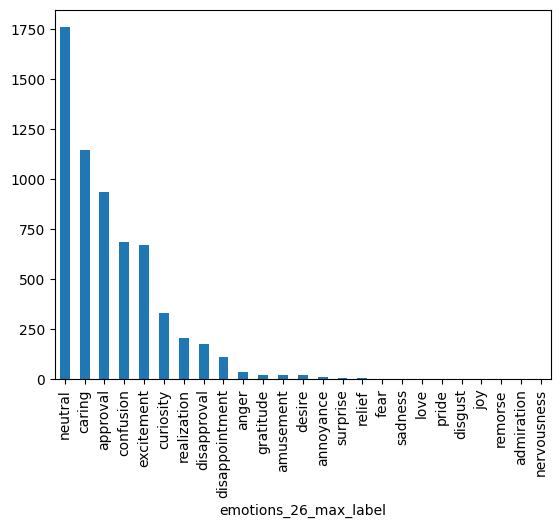

In [12]:
import pandas as pd
import pickle

with open("panorama-economico.pickle", "rb") as f:
    df = pickle.load(f)
    

df.sentiment_i.value_counts().values
df.emotions_6_max_label.value_counts().values
df.head(3)
df.emotions_26_max_label.value_counts().plot(kind="bar")